In [1]:
!pip install segyio
!pip install segysak
!pip install patchify
!pip install segmentation_models_3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 4.0 MB/s 
     |████████████████████████████████| 42 kB 415 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 


In [2]:

import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import segyio
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
import Augment as a
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from segysak.segy import segy_header_scan, segy_header_scrape, get_segy_texthead, segy_loader
from keras.metrics import MeanIoU
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model



Segmentation Models: using `tf.keras` framework.


/usr/local/lib/python3.7/dist-packages/segysak/segy/_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
# Normalization
def normalization(data, clip_factor=2.5):
  clipFactor = clip_factor
  std0 = np.std(data)
  stdClip = std0 * clipFactor
  clippedCube = np.clip(data, -stdClip, +stdClip)
  return np.asarray(clippedCube / stdClip, dtype='single')

## Dataset Preparation

In [ ]:
train_seismic_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/train/seis'
train_fault_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/train/fault'

valid_seismic_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/validation/seis'
valid_fault_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/validation/fault'

In [ ]:
train_seis_input = []
train_fault_output = []

index = [0, 63, 127]
for i in os.listdir(train_seismic_path):
  for j in index:
    # iline
    train_seis_input.append(np.reshape(np.fromfile(train_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    train_fault_output.append(np.reshape(np.fromfile(train_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    # xline
    train_seis_input.append(np.reshape(np.fromfile(train_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])
    train_fault_output.append(np.reshape(np.fromfile(train_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])

In [ ]:
valid_seis_input = []
valid_fault_output = []

for i in os.listdir(valid_seismic_path):
  for j in index:
    # iline
    valid_seis_input.append(np.reshape(np.fromfile(valid_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    valid_fault_output.append(np.reshape(np.fromfile(valid_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    # xline
    valid_seis_input.append(np.reshape(np.fromfile(valid_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])
    valid_fault_output.append(np.reshape(np.fromfile(valid_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])

In [ ]:
np.array(train_seis_input).tofile('/content/drive/MyDrive/UTP_dGB_Documents/data/train/seis/1200.dat')
np.array(train_fault_output).tofile('/content/drive/MyDrive/UTP_dGB_Documents/data/train/fault/1200.dat')

In [ ]:
np.array(valid_seis_input).tofile('/content/drive/MyDrive/UTP_dGB_Documents/data/validation/seis/1200.dat')
np.array(valid_fault_output).tofile('/content/drive/MyDrive/UTP_dGB_Documents/data/validation/fault/1200.dat')

## Data Augmentation

In [28]:
train_seis_input = np.reshape(np.fromfile('/content/drive/MyDrive/UTP_dGB_Documents/data/train/seis/1200.dat', dtype=np.single), (1200, 128, 128))
train_fault_output = np.reshape(np.fromfile('/content/drive/MyDrive/UTP_dGB_Documents/data/train/fault/1200.dat', dtype=np.single), (1200, 128, 128))
valid_seis_input = np.reshape(np.fromfile('/content/drive/MyDrive/UTP_dGB_Documents/data/validation/seis/1200.dat', dtype=np.single), (120, 128, 128))
valid_fault_output = np.reshape(np.fromfile('/content/drive/MyDrive/UTP_dGB_Documents/data/validation/fault/1200.dat', dtype=np.single), (120, 128, 128))

In [30]:
aug = a.Augment()

In [31]:
train_seis_input_gds = []
train_fault_output_gds = []

for i in range(len(train_seis_input)):
  p1 = train_seis_input[i, :, :]
  t1 = train_fault_output[i, :, :]
  aug_result = aug.GridDistort(p1, t1)
  train_seis_input_gds.append(aug_result[0])
  train_fault_output_gds.append(aug_result[1])

In [32]:
train_seis_input_shr = []
train_fault_output_shr = []

for i in range(len(train_seis_input)):
  p1 = train_seis_input[i, :, :]
  t1 = train_fault_output[i, :, :]
  aug_result = aug.Sharpen(p1, t1)
  train_seis_input_shr.append(aug_result[0])
  train_fault_output_shr.append(aug_result[1])

In [33]:
train_seis_input_aug = np.append(train_seis_input_gds, np.array(train_seis_input_shr), axis=0)
train_fault_output_aug = np.append(train_fault_output_gds, np.array(train_fault_output_shr), axis=0)


In [36]:
train_seis_input = np.append(train_seis_input, train_seis_input_aug, axis=0)
train_fault_output = np.append(train_fault_output, train_fault_output_aug, axis=0)


In [37]:
X_train = np.stack((train_seis_input,)*3, axis=-1)
X_test = np.stack((valid_seis_input,)*3, axis=-1)

train_mask = np.expand_dims(train_fault_output, axis=3)
y_train = tf.keras.utils.to_categorical(train_mask, num_classes=2)
test_mask = np.expand_dims(valid_fault_output, axis=3)
y_test = tf.keras.utils.to_categorical(test_mask, num_classes=2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3600, 128, 128, 3)
(120, 128, 128, 3)
(3600, 128, 128, 2)
(120, 128, 128, 2)


In [38]:
X_train_norm = normalization(X_train)
X_test_norm = normalization(X_test)


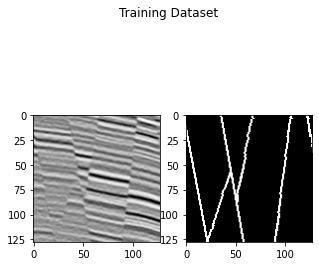

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].imshow(X_train_norm[1, :, :, 1].T, cmap='Greys')
ax[1].imshow(y_train[1, :, :, 1].T, cmap='Greys_r')
fig.suptitle('Training Dataset')
plt.show()


## Training

In [ ]:
batch_size = 8
image_size = 128

##### UNet

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    # encoder
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    # bridge
    bn = bottleneck(p4, f[4])
    
    # decoder
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(2, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


In [ ]:
model_unet = UNet()
model_unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

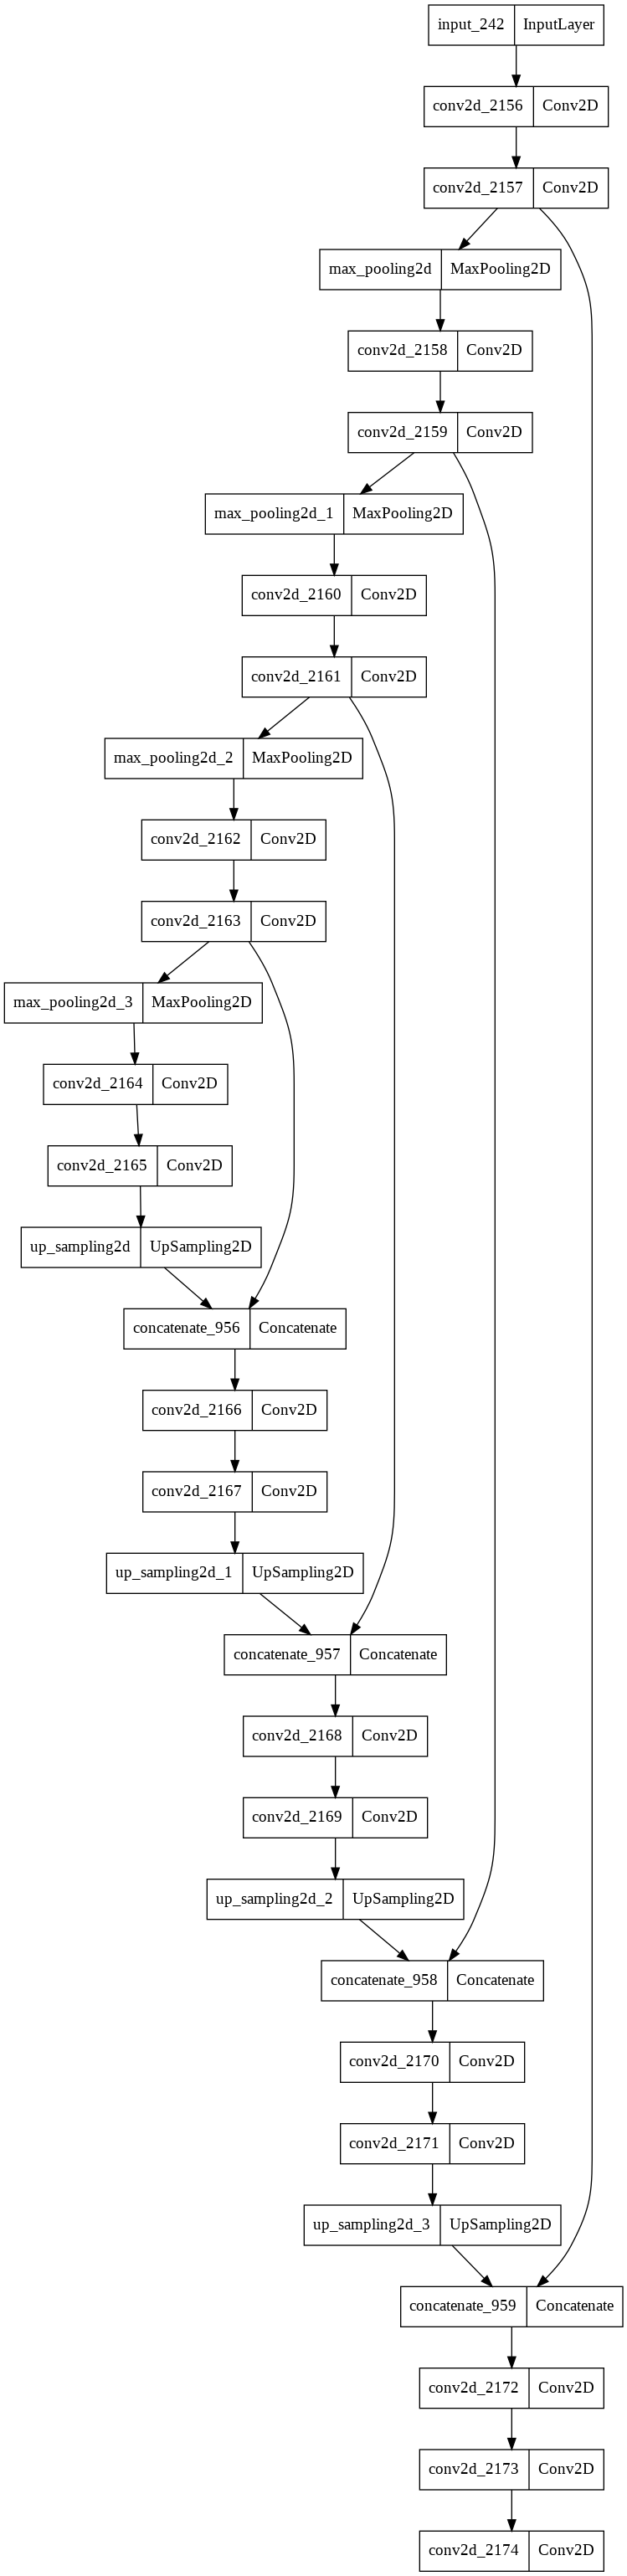

In [ ]:
plot_model(model_unet)

In [ ]:
train_steps = len(X_train_norm)//batch_size
valid_steps = len(X_test_norm)//batch_size

In [ ]:
history_1 = model_unet.fit(X_train_norm, 
                    y_train,
                    batch_size=batch_size, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test_norm, y_test), ) # callbacks=EarlyStopping(monitor='val_acc', mode='max',patience=10))

Epoch 1/100
450/450 [==============================] - 14s 25ms/step - loss: 0.2109 - acc: 0.9410 - val_loss: 0.1490 - val_acc: 0.9514
Epoch 2/100
450/450 [==============================] - 11s 25ms/step - loss: 0.1307 - acc: 0.9553 - val_loss: 0.1234 - val_acc: 0.9574
Epoch 3/100
450/450 [==============================] - 11s 24ms/step - loss: 0.1154 - acc: 0.9592 - val_loss: 0.1204 - val_acc: 0.9595
Epoch 4/100
450/450 [==============================] - 11s 24ms/step - loss: 0.1075 - acc: 0.9611 - val_loss: 0.1121 - val_acc: 0.9603
Epoch 5/100
450/450 [==============================] - 11s 24ms/step - loss: 0.1022 - acc: 0.9623 - val_loss: 0.1098 - val_acc: 0.9613
Epoch 6/100
450/450 [==============================] - 10s 23ms/step - loss: 0.0971 - acc: 0.9635 - val_loss: 0.1172 - val_acc: 0.9610
Epoch 7/100
450/450 [==============================] - 11s 23ms/step - loss: 0.0926 - acc: 0.9644 - val_loss: 0.1209 - val_acc: 0.9611
Epoch 8/100
450/450 [==============================] - 

##### VGG19

In [ ]:
def vgg19_model():
    
    img_input = Input((image_size, image_size, 3))
        
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPool2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPool2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    pool3 = MaxPool2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    pool4 = MaxPool2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    pool5 = MaxPool2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # decoder
    score_c5 = Conv2D(2, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(pool5)
    up_c5 = Conv2DTranspose(2, (2, 2), strides=(2, 2), padding='valid')(score_c5)
    
    score_c4 = Conv2D(2, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(pool4)
    fuse_16 = Add()([score_c4, up_c5])
    up_c4 = Conv2DTranspose(2, (2, 2), strides=(2, 2), padding='valid')(fuse_16)
    
    score_c3 = Conv2D(2, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(pool3)
    fuse_32 = Add()([score_c3, up_c4])
    up_c3 = Conv2DTranspose(2, (8, 8), strides=(8, 8), padding='valid', activation='sigmoid')(fuse_32)

    model = Model(inputs=img_input, outputs=up_c3, name='vgg19')
    
    return model

In [ ]:
model_vgg = vgg19_model()
model_vgg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

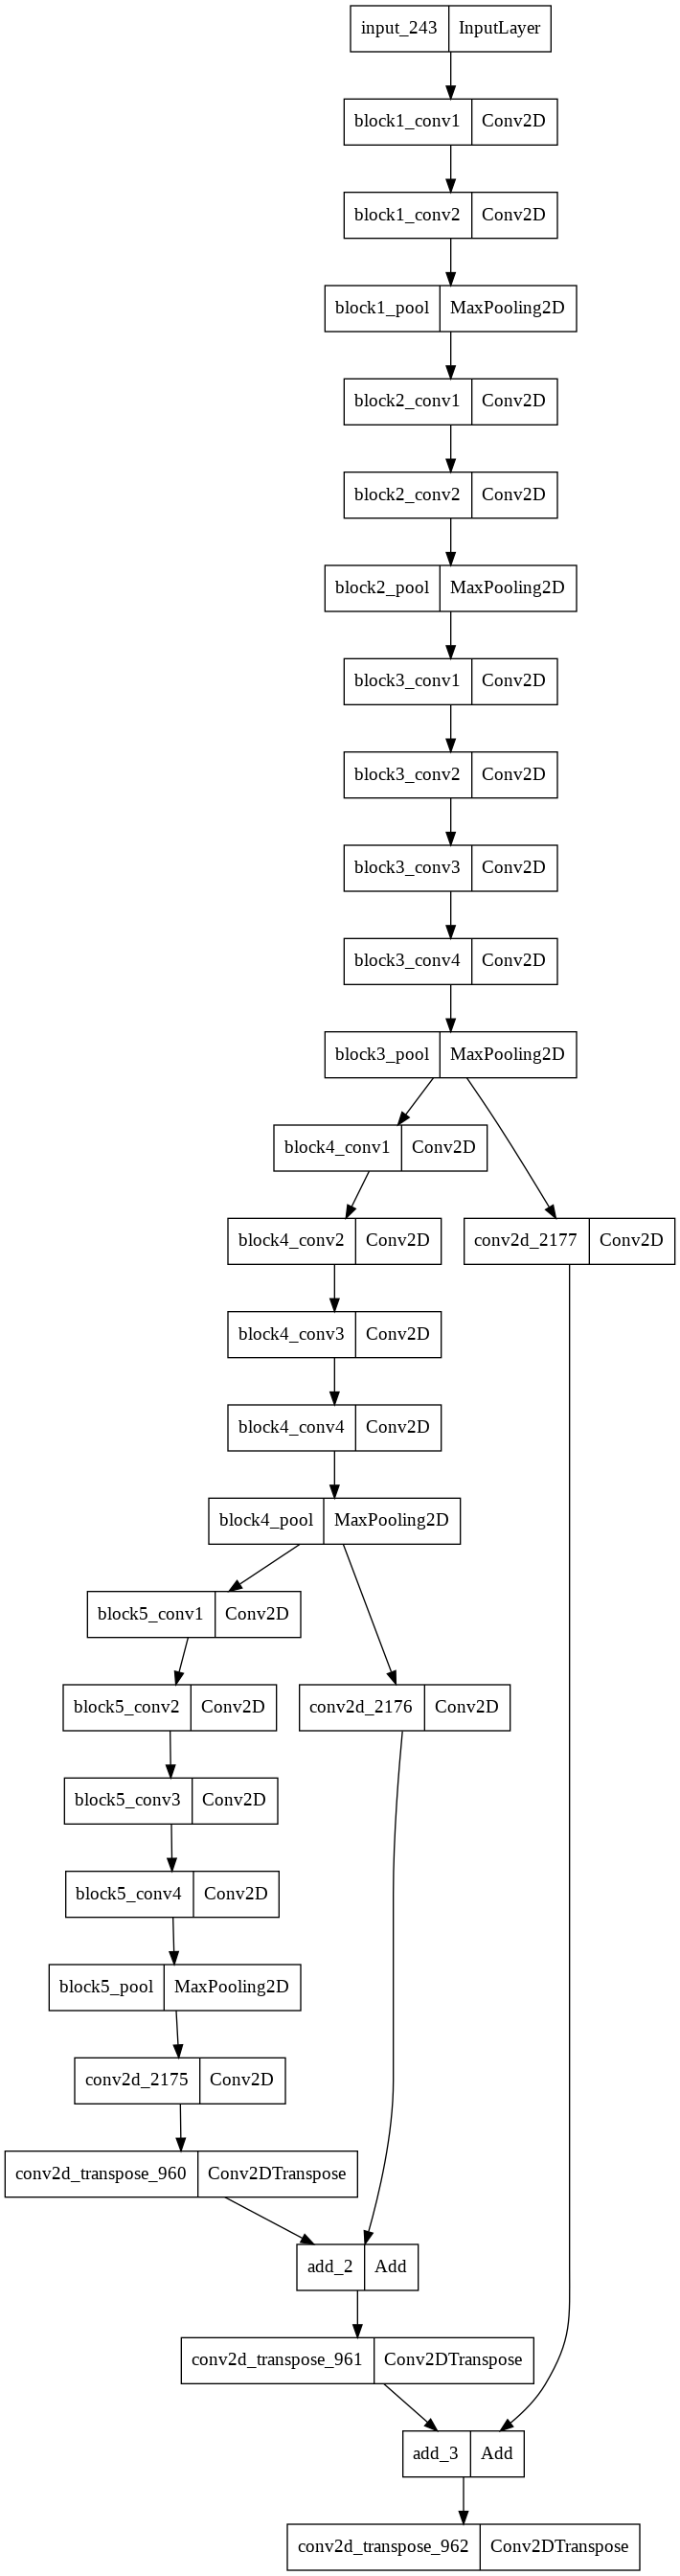

In [ ]:
plot_model(model_vgg)

In [ ]:
history_2 = model_vgg.fit(X_train_norm, 
                    y_train,
                    batch_size=batch_size, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test_norm, y_test), ) # callbacks=EarlyStopping(monitor='val_acc', mode='max',patience=10))

Epoch 1/100
450/450 [==============================] - 49s 106ms/step - loss: 0.2776 - acc: 0.9159 - val_loss: 0.1880 - val_acc: 0.9352
Epoch 2/100
450/450 [==============================] - 48s 106ms/step - loss: 0.1690 - acc: 0.9387 - val_loss: 0.1546 - val_acc: 0.9379
Epoch 3/100
450/450 [==============================] - 48s 106ms/step - loss: 0.1459 - acc: 0.9412 - val_loss: 0.1474 - val_acc: 0.9403
Epoch 4/100
450/450 [==============================] - 48s 106ms/step - loss: 0.1391 - acc: 0.9422 - val_loss: 0.1419 - val_acc: 0.9406
Epoch 5/100
450/450 [==============================] - 48s 106ms/step - loss: 0.1353 - acc: 0.9427 - val_loss: 0.1418 - val_acc: 0.9414
Epoch 6/100
450/450 [==============================] - 48s 106ms/step - loss: 0.1307 - acc: 0.9433 - val_loss: 0.1387 - val_acc: 0.9417
Epoch 7/100
450/450 [==============================] - 48s 106ms/step - loss: 0.1272 - acc: 0.9437 - val_loss: 0.1443 - val_acc: 0.9415
Epoch 8/100
450/450 [===========================

##### UNet VGG19

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape, freeze=1):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ 
        Select Freeze layer 
        VGG 19, consist of 22 trainable layers
        Freeze = True, all layers freeze not fine tune
        Freeze = False, all layers fine tune
        Freeze = 1, 1 last layers freeze
        Freeze = 21, 1 last layers fine tune, else freeze
    """

    if freeze == True:
      for layer in vgg19.layers:
        layer.trainable = False
    elif freeze == False:
      for layer in vgg19.layers[:]:
        layer.trainable = True
    elif freeze > 0:
      for layer in vgg19.layers[:freeze]:
        layer.trainable = False
    elif freeze < 0:
      # n_freeze = -1*freeze
      for layer in vgg19.layers[freeze:]:
        layer.trainable = False
    # else:
    #   for layer in vgg19.layers[:-1*freeze]:
    #     layer.trainable = False
    
    for layer in vgg19.layers:
      print(layer, layer.trainable)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(2, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [ ]:
# input_shape = (128,128, 3)
# model_unet_vgg_1 = build_vgg19_unet(input_shape, freeze=True)
# model_unet_vgg_1.summary()
# model_unet_vgg_1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# model_unet_vgg_1.fit(X_train_norm, 
#                     y_train,
#                     batch_size=8, 
#                     epochs=100,
#                     verbose=1,
#                     validation_data=(X_test_norm, y_test), )

In [ ]:
n_layers = [False, -11]
all_unet_vgg_models = []
for i,j in enumerate(n_layers):
  print(f'Scenario {i}')
  input_shape = (128,128, 3)
  model_unet_vgg = build_vgg19_unet(input_shape, freeze=j)
  model_unet_vgg.summary()
  model_unet_vgg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
  model_unet_vgg.fit(X_train_norm, 
                    y_train,
                    batch_size=8, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test_norm, y_test), ) # callbacks=EarlyStopping(monitor='val_acc', mode='max',patience=10))
  all_unet_vgg_models.append(model_unet_vgg)

Scenario 0
80150528/80134624 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7efd453a0290> True
<keras.layers.convolutional.Conv2D object at 0x7efd458a06d0> True
<keras.layers.convolutional.Conv2D object at 0x7efd45865690> True
<keras.layers.pooling.MaxPooling2D object at 0x7efd4539aa10> True
<keras.layers.convolutional.Conv2D object at 0x7efd453efc10> True
<keras.layers.convolutional.Conv2D object at 0x7efd3a09b810> True
<keras.layers.pooling.MaxPooling2D object at 0x7efddcd8cad0> True
<keras.layers.convolutional.Conv2D object at 0x7efd3a0a4cd0> True
<keras.layers.convolutional.Conv2D object at 0x7efd3a0aa150> True
<keras.layers.convolutional.Conv2D object at 0x7efd3a0aa810> True
<keras.layers.convolutional.Conv2D object at 0x7efd3a0a4e50> True
<keras.layers.pooling.MaxPooling2D object at 0x7efd3a039f90> True
<keras.layers.convolutional.Conv2D object at 0x7efd3a03f590> True
<keras.layers.convolutional.Conv2D object at 0x7efd3a03e390> Tru

In [ ]:
model_unet_vgg_1 = all_unet_vgg_models[0]
model_unet_vgg_2 = all_unet_vgg_models[1]
# model_unet_vgg_3 = all_unet_vgg_models[2]
# model_unet_vgg_4 = all_unet_vgg_models[3]
# model_unet_vgg_5 = all_unet_vgg_models[4]
# model_unet_vgg_6 = all_unet_vgg_models[5]
# model_unet_vgg_7 = all_unet_vgg_models[6]


In [ ]:
# model_unet_vgg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
# plot_model(model_unet_vgg)

In [ ]:
# history_2 = model_unet_vgg.fit(X_train_norm, 
#                     y_train,
#                     batch_size=8, 
#                     epochs=100,
#                     verbose=1,
#                     validation_data=(X_test_norm, y_test), ) # callbacks=EarlyStopping(monitor='val_acc', mode='max',patience=10))

In [ ]:
# #plot the training and validation IoU and loss at each epoch
# loss_1 = history_1.history['loss']
# val_loss_1 = history_1.history['val_loss']
# epochs = range(1, len(loss_1) + 1)
# plt.plot(epochs, loss_1, 'y-', label='UNet Training loss')
# plt.plot(epochs, val_loss_1, 'r-', label='UNet Validation loss')
# loss_2 = history_2.history['loss']
# val_loss_2 = history_2.history['val_loss']
# epochs = range(1, len(loss_2) + 1)
# plt.plot(epochs, loss_2, 'y--', label='UNet VGG Training loss')
# plt.plot(epochs, val_loss_2, 'r--', label='UNet VGG Validation loss')
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.ylim([0, 1])
# plt.legend()
# plt.show()

# acc_1 = history_1.history['acc']
# val_acc_1 = history_1.history['val_acc']
# acc_2 = history_2.history['acc']
# val_acc_2 = history_2.history['val_acc']
# epochs = range(1, len(acc_1) + 1)
# plt.plot(epochs, acc_1, 'y-', label='UNet Training Acc')
# plt.plot(epochs, val_acc_1, 'r-', label='UNet Validation Acc')
# epochs = range(1, len(acc_2) + 1)
# plt.plot(epochs, acc_2, 'y--', label='UNet VGG Training Acc')
# plt.plot(epochs, val_acc_2, 'r--', label='UNet VGG Validation Acc')
# plt.title('Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Acc')
# plt.ylim([0.8, 1])
# plt.legend()
# plt.show()

In [ ]:
# #Predict on the test data
# # y_pred_1=model_unet.predict(X_test_norm)
# # y_pred_argmax_1=np.argmax(y_pred_1, axis=3)
# y_pred_2=model_vgg.predict(X_test_norm)
# y_pred_argmax_2=np.argmax(y_pred_2, axis=3)
# y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
# # IOU_keras_1 = MeanIoU(num_classes=2)  
# # IOU_keras_1.update_state(y_test_argmax, y_pred_argmax_1)
# # print("Mean IoU Test UNet=", IOU_keras_1.result().numpy())
# IOU_keras_2 = MeanIoU(num_classes=2)  
# IOU_keras_2.update_state(y_test_argmax, y_pred_argmax_2)
# print("Mean IoU Test VGG=", IOU_keras_2.result().numpy())

In [ ]:
# plt.figure(figsize=(15, 3))
# ax1 = plt.subplot(141)
# ax2 = plt.subplot(142)
# ax3 = plt.subplot(143)
# ax4 = plt.subplot(144)
# randil = np.random.randint(0, len(X_test_norm), 1)[0]
# ax1.imshow(X_test_norm[randil, : , :, 1].T)
# ax2.imshow(y_test_argmax[randil, : , :].T)
# # ax3.imshow(y_pred_argmax_1[randil, : , :].T)
# ax4.imshow(y_pred_argmax_2[randil, : , :].T)
# ax1.set_title('Input')
# ax2.set_title('Ground Truth')
# ax3.set_title('UNet')
# ax4.set_title('UNet VGG')
# plt.tight_layout()
# plt.show()

In [ ]:
# model_unet.save('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_1200data.h5')

In [ ]:
# model_unet_vgg.save('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_vgg_1200data.h5')

In [ ]:
model_unet_vgg_1.save('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_vgg_trainable.h5')
model_unet_vgg_2.save('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_vgg_11_last_layers.h5')


## Evaluation

In [6]:
model_unet_vgg_1 = load_model('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_vgg_trainable.h5', compile=False)

In [7]:
model_unet_vgg_2 = load_model('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_vgg_11_last_layers.h5', compile=False)

In [5]:
# Prediction
seismic = segyio.tools.cube('/content/drive/MyDrive/UTP_dGB_Documents/data/torosa-seismic/PloverTorosaSubArea_1015-1527_1500-3300_2-4_32bit.sgy')
# seismicclip = seismic[:512, :1792, :256]
seismic.shape

(513, 1801, 276)

In [9]:
seisnorm = normalization(seismic)

In [10]:
vm = np.percentile(seisnorm, 99)

In [11]:
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,0,ncolors)
color_array[253:256] = [1, 0.0, 0., 1]
map_object = LinearSegmentedColormap.from_list(name='fault',colors=color_array)
plt.register_cmap(cmap=map_object)

In [12]:
def prediction(seismic, model, mode='inline'):
  # Append 2D seismic into 3D seismic
  if mode=='inline':
    predicted = []
    for i in range(seismic.shape[0]):
      val_input = seismic[i, :, :]
      patches = patchify(val_input, (128, 128), step=128)
      predicted_patches = []
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
          single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
          single_patch_prediction = model.predict(single_patch_3ch_input)
          single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=3)[0,:,:]
          predicted_patches.append(single_patch_prediction_argmax)
      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]))
      reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
      predicted.append(reconstructed_seismic)
    return np.array(predicted)
  elif mode=='crossline':
    predicted = []
    for i in range(seismic.shape[1]):
      val_input = seismic[:, i, :]
      patches = patchify(val_input, (128, 128), step=128)
      predicted_patches = []
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
          single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
          single_patch_prediction = model.predict(single_patch_3ch_input)
          single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=3)[0,:,:]
          predicted_patches.append(single_patch_prediction_argmax)
      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]))
      reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
      predicted.append(reconstructed_seismic)
    return np.array(predicted)

In [ ]:
def evaluation(seismic, model, il=53, xl=24):
  y_pred=model.predict(X_test_norm)
  y_pred_argmax=np.argmax(y_pred, axis=3)
  y_test_argmax = np.argmax(y_test, axis=3)
  IOU_keras = MeanIoU(num_classes=2)  
  IOU_keras.update_state(y_test_argmax, y_pred_argmax)
  print("Mean IoU Test VGG=", IOU_keras.result().numpy())
  predicted_il = prediction(seisnorm, model, mode='inline')
  predicted_xl = prediction(seisnorm, model, mode='crossline')
  predicted_xl_transposed = np.moveaxis(predicted_xl, 1, 0)
  combined = predicted_il + predicted_xl_transposed
  combined[combined > 0] = 1
  fig, ax = plt.subplots(1, 1, figsize=(6, 5))
  ax.imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
  ax.imshow(predicted_il[il, :, :].T, cmap='fault')
  plt.suptitle('Inline')
  plt.show()
  fig, ax = plt.subplots(1, 1, figsize=(6, 5))
  ax.imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
  ax.imshow(predicted_xl[xl, :, :].T, cmap='fault')
  plt.suptitle('Crossline')
  plt.show()

In [ ]:
# evaluation(seisnorm, model_unet_vgg_1)

model_unet_vgg_1
Mean IoU Test VGG= 0.75479686


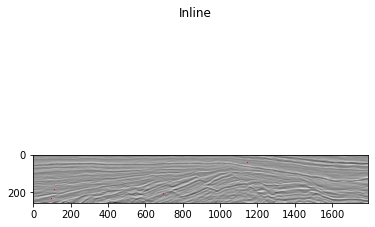

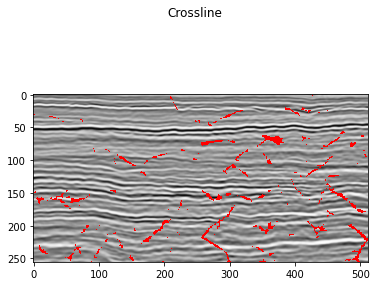

model_unet_vgg_2
Mean IoU Test VGG= 0.75728965


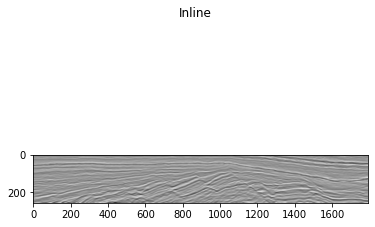

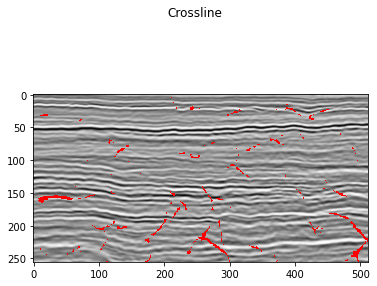

In [ ]:
all_models = [model_unet_vgg_1, model_unet_vgg_2]
models_name = ['model_unet_vgg_1', 'model_unet_vgg_2' ]

for i,j in zip(all_models, models_name):
  print(j)
  evaluation(seisnorm, i)

In [13]:
unet_vgg_1_predicted_il = prediction(seismic, model_unet_vgg_1, mode='inline')
unet_vgg_1_predicted_xl = prediction(seismic, model_unet_vgg_1, mode='crossline')

In [14]:
unet_vgg_2_predicted_il = prediction(seisnorm, model_unet_vgg_2, mode='inline')
unet_vgg_2_predicted_xl = prediction(seisnorm, model_unet_vgg_2, mode='crossline')

In [ ]:
# def prediction(model):
#   il_range = np.arange(0, 640, 128)
#   pred_3d = []
#   for i in range(384):
#     pred_2d = []
#     for j in range(0, 4):
#       il_min = il_range[j]
#       il_max = il_range[j+1]
#       seis = seismic[il_min:il_max, i, :]
#       pred = np.stack((seis,)*3, axis=-1)
#       pred_2d.append(pred)
#     pred_3d.append(np.vstack(np.argmax(model.predict(np.array(pred_2d)), axis=3)))
#   return np.array(pred_3d).reshape(512, 384, 128)

In [ ]:
# unet_prediction = prediction(seisnorm, model_unet)

In [ ]:
# unet_vgg_prediction = prediction(seisnorm, model_unet_vgg)

(array([ 6231896.,  7112911., 15801140., 34496147., 56879836., 50880914.,
        35423730., 15788962.,  6240448.,  6025040.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

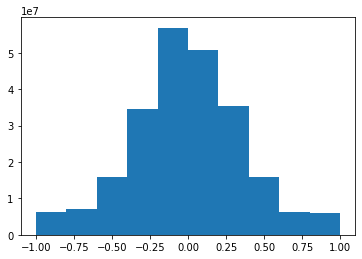

In [48]:
plt.hist(seisnorm.reshape(-1,1))

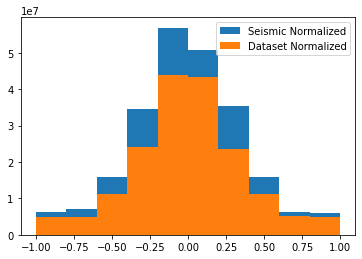

In [52]:
plt.hist(seisnorm.reshape(-1,1), label='Seismic Normalized')
plt.hist(X_train_norm.reshape(-1,1), label='Dataset Normalized')
plt.legend();

In [56]:
pd.DataFrame(seisnorm.reshape(-1,1),columns=['Seismic Normalized']).describe().T

,count,mean,std,min,25%,50%,75%,max
Seismic Normalized,234881024.0,-0.00203,0.369914,-1.0,-0.224332,-3.791206e-08,0.224332,1.0


In [57]:
pd.DataFrame(X_train_norm.reshape(-1,1), columns=['Dataset Normalized']).describe().T

,count,mean,std,min,25%,50%,75%,max
Dataset Normalized,176947200.0,-0.000137,0.367866,-1.0,-0.204759,-0.001404,0.20272,1.0


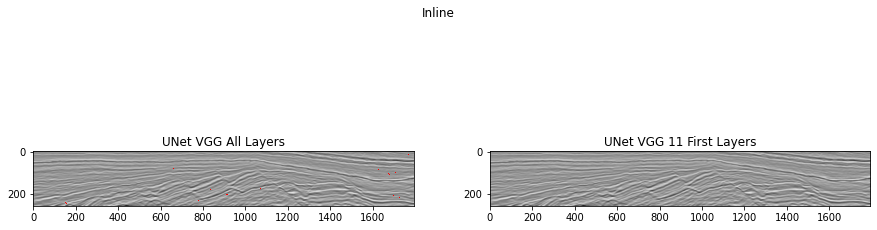

In [15]:
il = 53
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[0].imshow(unet_vgg_1_predicted_il[il, :, :].T, cmap='fault')
ax[0].set_title('UNet VGG All Layers')
ax[1].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[1].imshow(unet_vgg_2_predicted_il[il, :, :].T, cmap='fault')
ax[1].set_title('UNet VGG 11 First Layers')
plt.suptitle('Inline')
plt.show()


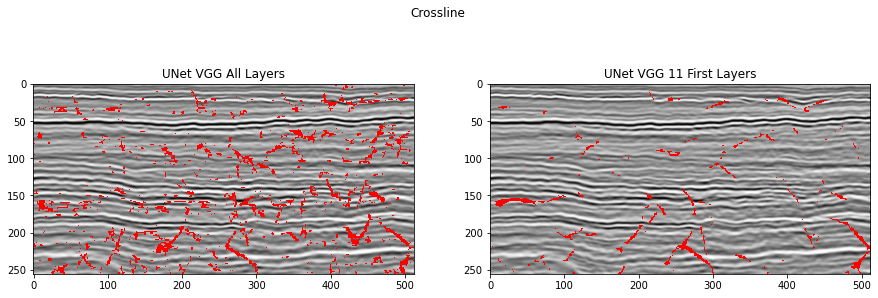

In [16]:
xl = 24
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[0].imshow(unet_vgg_1_predicted_xl[xl, :, :].T, cmap='fault')
ax[0].set_title('UNet VGG All Layers')
ax[1].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[1].imshow(unet_vgg_2_predicted_xl[xl, :, :].T, cmap='fault')
ax[1].set_title('UNet VGG 11 First Layers')
plt.suptitle('Crossline')
plt.show()


In [ ]:
# print(unet_predicted_il.shape)
# print(unet_predicted_xl.shape)
# print(unet_vgg_predicted_il.shape)
# print(unet_vgg_predicted_xl.shape)
# unet_predicted_xl_transposed = np.moveaxis(unet_predicted_xl, 1, 0)
# print(unet_predicted_xl_transposed.shape)
# unet_vgg_predicted_xl_transposed = np.moveaxis(unet_vgg_predicted_xl, 1, 0)
# print(unet_vgg_predicted_xl_transposed.shape)

In [ ]:
# combined_unet = unet_predicted_il + unet_predicted_xl_transposed
# combined_unet[combined_unet > 0] = 1
# combined_unet_vgg = unet_vgg_predicted_il + unet_vgg_predicted_xl_transposed
# combined_unet_vgg[combined_unet_vgg > 0] = 1

In [ ]:
# combined_unet_vgg.shape

In [ ]:
# il = 53
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
# ax[0].imshow(combined_unet[il, :, :].T, cmap='fault')
# ax[0].set_title('UNet')
# ax[1].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
# ax[1].imshow(combined_unet_vgg[il, :, :].T, cmap='fault')
# ax[1].set_title('UNet VGG')
# plt.suptitle('Inline')
# plt.show()

In [ ]:
# xl = 24
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
# ax[0].imshow(combined_unet[:, xl, :].T, cmap='fault')
# ax[0].set_title('UNet')
# ax[1].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
# ax[1].imshow(combined_unet_vgg[:, xl, :].T, cmap='fault')
# ax[1].set_title('UNet VGG')
# plt.suptitle('Crossline')
# plt.show()
